In [ ]:
# first thing we connect to my drive to get the dataset and the kaggle authentications
from google.colab import drive
drive.mount("/content/gdrive") # saving the files after the connection under gdrive directory

Mounted at /content/gdrive


In [ ]:
# importing modules that will be used
import os
import shutil
import IPython

In [ ]:
Workplace_dir = "/content/gdrive/MyDrive/ML_NNM/dog_cat"

for name in os.listdir(Workplace_dir):
  print(name)

dogs-cats-images.zip
train_dog_features.pkl
train_cats_features.pkl
test_dog_features.pkl
test_cats_features.pkl


In [ ]:
# unzipping the dataset
dataset_dir = "/content/gdrive/MyDrive/ML_NNM/dog_cat/dogs_cats_images.zip" 
!unzip "/content/gdrive/MyDrive/ML_NNM/dog_cat/dogs-cats-images.zip" 

Streaming output truncated to the last 5000 lines.
  inflating: dog vs cat/dataset/training_set/cats/cat.37.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.370.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3700.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3701.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3702.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3703.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3704.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3705.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3706.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3707.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3708.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3709.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.371.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3710.jpg  
  inflating: dog vs cat/dataset/training_se

In [ ]:
training_path = "/content/dog vs cat/dataset/training_set"
testing_path = "/content/dog vs cat/dataset/test_set"

In [ ]:
# creating a feature reader for the features that will be extracted from the images
import pickle
# creating a function that will save the features to save computational power
def features_reader(file_name, dict_to_be_saved="nothingforeading", state = "r"):
  if ".pkl" not in file_name: 
    file_name = file_name + ".pkl"
  if state == "r":
    with open(file_name, "rb") as file:
      output = pickle.load(file)
    return output
  elif state == "rd":
    file_name = f"/content/gdrive/MyDrive/ML_NNM/dog_cat/{file_name}"
    with open(file_name, "rb") as file:
      output = pickle.load(file)
    return output
  elif state == "w":
    with open(file_name, "wb") as file:
      pickle.dump(dict_to_be_saved, file)
      print("Dictionary have been saved successfully")
  elif state == "wd": # save to the drive
      with open(file_name, "wb") as file:
        pickle.dump(dict_to_be_saved, file)
        shutil.copy(f"/content/{file_name}", f"/content/gdrive/MyDrive/ML_NNM/dog_cat/{file_name}")
        print("Dictionary have been saved to the drive successfully")
  else:
    print("You are using a wrong state")

In [ ]:
# extracting features from the images

# importing some models
import tensorflow as tf
import tensorflow.keras as kr
from keras.applications.resnet import ResNet101 
from keras.models import Model
import keras.preprocessing.image as Im_keras # for loading the images and converting them to array

def load_image_keras(image_path):
  # First we load the image at the shape of 224, 224 for the model Vgg16
  image = Im_keras.load_img(image_path, target_size=(224, 224))
  # converting the Image to an array
  image = Im_keras.img_to_array(image)
  # reshape the data for the model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  return image
def extract_features_resnet(directory_path):
  # creating a indication of progress
  counter = 0
  # inilizing the model : ResNet101
  model = ResNet101()
  # restructing the model so we just use it for feature extraction not classifcation
  model = Model(inputs=model.inputs, outputs=model.layers[-2].output) # outputs is removed to get rid of the final layer
  features = {} # setting the features dict
  for name in os.listdir(directory_path):
    im_path = directory_path +"/"+ name
    image = load_image_keras(im_path)
    # preprocessing the image
    image = preprocess_input(image)
    # extracting features using the model
    im_features = model.predict(image, verbose = 0) # the verbose parameter for the animation 1 indicate a simple progress bar
    # saving the data in the dictionary             # verbose 2 will show epochs
    features[name] = im_features
    # indication of progress
    counter += 1
    if counter%100 ==0:
      print("{} images have features extracted".format(counter))
  return features
  

In [ ]:
# extracting features using resnet for the dogs and cats images
training_dogs_features = extract_features_resnet(training_path + "/dogs")
training_cats_features = extract_features_resnet(training_path + "/cats")
# saving the dogs and cat features features 
features_reader("train_dog_features", training_dogs_features, state = "wd")
features_reader("train_cats_features", training_cats_features, state = "wd")
# loading
training_dogs_features = features_reader("train_dog_features", state = "rd")
training_cats_features = features_reader("train_cats_features", state = "rd")


In [ ]:
import pandas as pd
import numpy as np

dog_train_features_path = "/content/gdrive/MyDrive/ML_NNM/dog_cat/train_dog_features"
cat_train_features_path = "/content/gdrive/MyDrive/ML_NNM/dog_cat/train_cats_features"
df = pd.DataFrame(columns = ['image_name','features','label'])
# specifying the columns
#df.columns = ['image_name','features','label']
# preparing the data for the model
for key, features in training_dogs_features.items():
  row = {'image_name': key , 'features': features[0], 'label': "dog"}
  #print(row)
  df = df.append(row, ignore_index=True)
for key, features in training_cats_features.items():
  row = {'image_name': key , 'features': features[0], 'label': "cat"}
  df =df.append(row, ignore_index=True)  

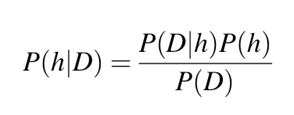


probability of labels given features equal to the probability of feartures given labels multipled with probability of labels divided by probability of features

8000


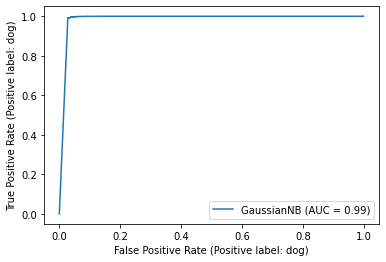

In [ ]:
dog_train_features_path = "/content/gdrive/MyDrive/ML_NNM/dog_cat/train_dog_features"
cat_train_features_path = "/content/gdrive/MyDrive/ML_NNM/dog_cat/train_cats_features"
# creating the model
from sklearn.metrics import RocCurveDisplay

features = np.array(df["features"])
print(len(features))
from sklearn.naive_bayes import GaussianNB # naive payes
gnb = GaussianNB()
# fitting the data on the model
gnb.fit(list(features), df["label"])
gnb_disp = RocCurveDisplay.from_estimator(gnb, list(features), df["label"])

In [ ]:
# extracting features from the testing images
testing_dogs_features = extract_features_resnet(testing_path + "/dogs")
testing_cats_features = extract_features_resnet(testing_path + "/cats")
# saving the dogs and cat features features 
features_reader("test_dog_features", testing_dogs_features, state ="wd")
features_reader("test_cats_features", testing_cats_features, state ="wd")
# loading
testing_dogs_features = features_reader("test_dog_features", state = "rd")
testing_cats_features = features_reader("test_cats_features", state = "rd")


In [ ]:
import pandas as pd
import numpy as np

dog_test_features_path = "/content/gdrive/MyDrive/ML_NNM/dog_cat/train_dog_features"
cat_test_features_path = "/content/gdrive/MyDrive/ML_NNM/dog_cat/train_cats_features"
df_test = pd.DataFrame(columns = ['image_name','features','label'])
# specifying the columns

# preparing the data for the model
for key, features in testing_dogs_features.items():
  row = {'image_name': key , 'features': features[0], 'label': "dog"}
  df_test = df_test.append(row, ignore_index=True)
for key, features in testing_cats_features.items():
  row = {'image_name': key , 'features': features[0], 'label': "cat"}
  df_test = df_test.append(row, ignore_index=True)  

In [ ]:
df_test.head(10)

,image_name,features,label
0,dog.4850.jpg,"[0.10251522, 0.15948161, 0.026189478, 0.0, 1.3...",dog
1,dog.4405.jpg,"[0.16016142, 0.2679867, 0.24860254, 0.4335943,...",dog
2,dog.4535.jpg,"[0.0, 0.4582443, 0.0, 0.0, 0.30821812, 0.01823...",dog
3,dog.4179.jpg,"[0.2437387, 0.1575025, 0.0039458177, 0.3267684...",dog
4,dog.4990.jpg,"[0.23060502, 0.08270868, 0.21032761, 0.0399789...",dog
5,dog.4005.jpg,"[0.27954915, 0.0, 0.0, 0.10014756, 0.09843636,...",dog
6,dog.4428.jpg,"[0.43836492, 0.0, 0.41143727, 0.02787066, 0.03...",dog
7,dog.4363.jpg,"[0.0, 0.29031667, 0.0, 0.034270067, 1.6927664,...",dog
8,dog.4692.jpg,"[0.13170737, 0.08545209, 0.039652146, 0.079593...",dog
9,dog.4002.jpg,"[0.013802524, 0.01369905, 0.0, 0.029532276, 0....",dog


Accuracy: 0.98


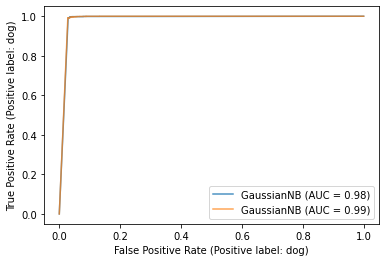

In [ ]:
# loading metrics 
import matplotlib.pyplot as plt
from sklearn import metrics
features = np.array(df_test["features"])
# validation for the model
predicted= gnb.predict(list(features))
print("Accuracy:",metrics.accuracy_score(df_test["label"], predicted))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(gnb, list(features), df_test["label"], ax=ax, alpha=0.8)
gnb_disp.plot(ax=ax, alpha=0.7)

In [ ]:
# showing some images with their crosponding caption
# training_path = "/content/dog vs cat/dataset/training_set"
# testing_path = "/content/dog vs cat/dataset/test_set"
# visulizing an image from the data sets
from IPython.display import Image, display

for image_name in df_test["image_name"]:
  image_fe = df_test[(df_test["image_name"] == image_name)]
  print(image_name)
  image_label = image_fe["label"].astype("string")
  try:
    if("dog" in image_name):
      image = Image(filename=testing_path+"/dogs/"+image_name)
      display(image)
    else:
      image = Image(filename=testing_path+"/cats/"+image_name)
      display(image)
  except:
    pass
  # the image features
  #image_features = df[df["image_name"] == image_name]
  features = np.array(image_fe["features"])
  #print(features)
  predict = gnb.predict([features[0]])
  print(f"prediction : {predict}")